## Libraries

In [1]:
from SoundDSConv import SoundDSConv
from AutoEncoderConv import AutoEncoderConv

import torch
#import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import torchaudio
from torchaudio import transforms
import os
import pandas as pd
import matplotlib.pyplot as plt

## Data Import

In [2]:
path_do_data_dir = 'DATA/'

# Get the list of files in the 'Piano Loops' directory using os.listdir()
piano_file_list = [path_do_data_dir + 'Piano Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Piano Loops')]

# Create a pandas DataFrame with the "path_to_data" and "Instrument" columns for "Piano" entries
piano_df = pd.DataFrame({"path_to_data": piano_file_list, "Instrument": "Piano"})

# Get the list of files in the 'Guitar Loops' directory using os.listdir()
guitar_file_list = [path_do_data_dir + 'Guitar Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Guitar Loops')]

# Create a DataFrame with the "path_to_data" and "Instrument" columns for "Guitar" entries
guitar_df = pd.DataFrame({"path_to_data": guitar_file_list, "Instrument": "Guitar"})


In [3]:
# Create Datasets
sample_rate = 8000
duration = 4
piano_ds = SoundDSConv(piano_df, sr = sample_rate, duration = duration)
guitar_ds = SoundDSConv(guitar_df, sr = sample_rate, duration = duration)

# Split train
piano_ds_train, piano_ds_test = random_split(piano_ds, [len(piano_ds) - 2, 2])
guitar_ds_train, guitar_ds_test = random_split(piano_ds, [len(piano_ds) - 2, 2])

1. Change the random_split before because of leake

## Check shape of dataset

In [4]:
print(piano_ds[0].shape)
#print(autoencoder(piano_ds[0]).shape)

torch.Size([1, 513, 94])


## Create Model

In [5]:
encoder_layers = {'channels': [1, 7, 16],
                  'kernel_conv': [5, 5],
                  'padding': [1, 1],
                  'stride_conv': [1,1],
                  'kernel_pool': [2, 2],
                  'stride_pool': [2, 2]}

decoder_layers = {'channels': [16, 7, 1],
                  'kernel': [5,(5,2)],
                  'padding': [0, 0],
                  'stride':[2,2]}

autoencoder = AutoEncoderConv(encoder_layers, decoder_layers)

In [6]:
print(autoencoder)

AutoEncoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 7, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(7, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 7, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(7, 1, kernel_size=(5, 2), stride=(2, 2))
  )
)


## Train the model

In [7]:
loss = autoencoder.train(piano_ds_train, batch_size = 10, epochs = 20, lr = 0.001, criterion = 'mae',
                         optimizer = 'adam', verbose = 40)

Epoch: 1 | Batch number: 40 | Loss: 3.082531690597534 | Time: 3.52 s
Epoch: 1 | Batch number: 80 | Loss: 8.232601165771484 | Time: 3.48 s
Epoch: 2 | Batch number: 40 | Loss: 4.745607376098633 | Time: 5.17 s
Epoch: 2 | Batch number: 80 | Loss: 3.808549165725708 | Time: 3.23 s
Epoch: 3 | Batch number: 40 | Loss: 4.999024868011475 | Time: 5.03 s
Epoch: 3 | Batch number: 80 | Loss: 3.8404617309570312 | Time: 3.21 s
Epoch: 4 | Batch number: 40 | Loss: 3.618528366088867 | Time: 4.94 s
Epoch: 4 | Batch number: 80 | Loss: 3.147963523864746 | Time: 3.09 s
Epoch: 5 | Batch number: 40 | Loss: 3.550410747528076 | Time: 4.85 s
Epoch: 5 | Batch number: 80 | Loss: 2.7495996952056885 | Time: 3.23 s
Epoch: 6 | Batch number: 40 | Loss: 6.008850574493408 | Time: 4.99 s
Epoch: 6 | Batch number: 80 | Loss: 4.435546398162842 | Time: 3.09 s
Epoch: 7 | Batch number: 40 | Loss: 3.5340285301208496 | Time: 4.96 s
Epoch: 7 | Batch number: 80 | Loss: 2.7750024795532227 | Time: 3.16 s
Epoch: 8 | Batch number: 40 | 

## Plotting the error

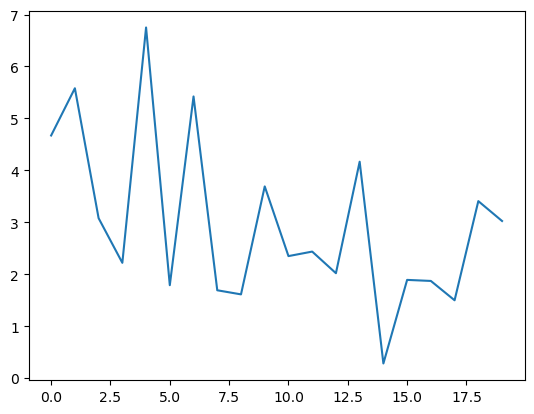

In [8]:
plt.plot(loss)
plt.show()

## Testing it

In [9]:
# From spectrogram to waveform
def recover_waveform(spec):
        griffin_lim = transforms.GriffinLim(n_fft=1024,
                                             hop_length=513)

        rec_waveform = griffin_lim(spec)

        return rec_waveform

In [10]:
def cap(tensor, threshold):
    return torch.where((tensor >= 0) & (tensor <= threshold), torch.tensor(0), tensor)

In [11]:
# Predicting
testing = piano_ds_test[1]
testing_out = cap(autoencoder(testing), 0)

# Reshaping
testing_out_shaped = testing_out.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach()
testing_shaped = testing.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach()

# Capping minimum value
testing_out_shaped = testing_out_shaped.clamp(min = 0.0)
print(testing_out_shaped.shape)

in_wave = recover_waveform(testing_shaped)
out_wave = recover_waveform(testing_out_shaped)

input_path = "input_audio.wav"
output_path = "output_audio.wav"
torchaudio.save(input_path, in_wave, sample_rate)
torchaudio.save(output_path, out_wave, sample_rate)

torch.Size([1, 513, 94])


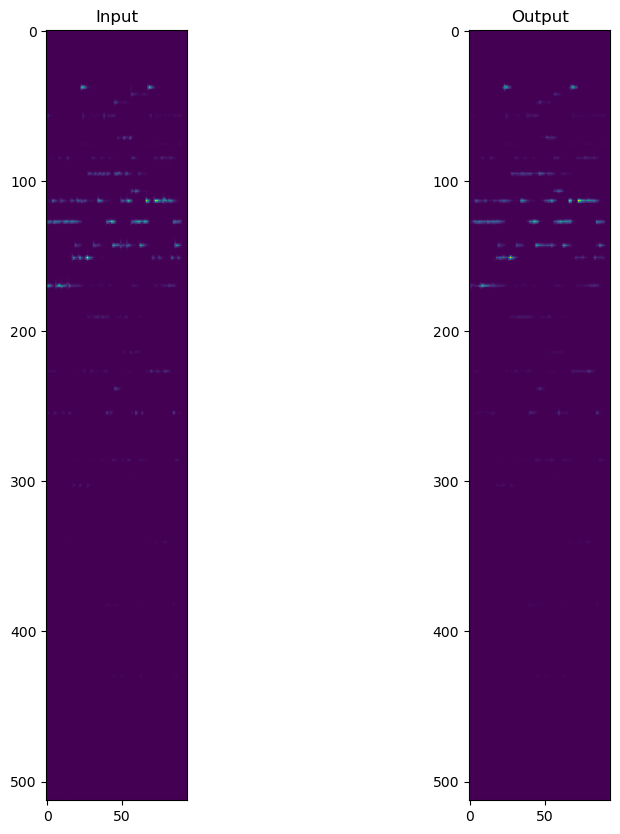

In [12]:
testing_shaped = testing_shaped.numpy().reshape(piano_ds.spec_size[0], piano_ds.spec_size[1])
testing_out_shaped = testing_out_shaped.numpy().reshape(piano_ds.spec_size[0], piano_ds.spec_size[1])
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(testing_shaped)
ax1.title.set_text('Input')
ax2 = fig.add_subplot(1, 2, 2)
plt.imshow(testing_out_shaped)
ax2.title.set_text('Output')
plt.show()
